<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw13/Homework13_realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 435 (delta 114), reused 82 (delta 78), pack-reused 242
Receiving objects: 100% (435/435), 70.44 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=ecccdba51c58b855632f4289570efeaa4ae592e462dec7aa64277978730d61a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-gunwaeju/wheels/55/59/29/0fb1c6356521

In [ ]:
from dul_2021.utils.hw13_utils import *

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
!pip install einops

In [ ]:
import os
import numpy as np
import copy
from itertools import chain
import einops
import math

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question 1: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



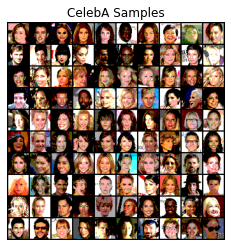

In [ ]:
visualize_q1_data()

## Part (a): RealNVP


Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 256, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=128, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=128
  relu()
  conv2d(n_filters, n_filters=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # todo: calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Main classes

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.block = nn.Sequential(nn.Conv2d(n_filters, n_filters, 1),
                               nn.ReLU(),
                               nn.Conv2d(n_filters, n_filters, 3, 1, 1),
                               nn.ReLU(),
                               nn.Conv2d(n_filters, n_filters, 1))
    
  def forward(self, x):
    return x + self.block(x)

In [ ]:
class Resnet(nn.Module):
  def __init__(self, n_filters, in_filters=3, out_filters=6, n_block=6):
    super().__init__()
    res_blocks = nn.Sequential(*[ResBlock(n_filters) for _ in range(n_block)])
    self.convs = nn.Sequential(nn.Conv2d(in_filters, n_filters, 3, 1, 1),
                               res_blocks,
                               nn.ReLU(),
                               nn.Conv2d(n_filters, out_filters, 3, 1, 1))
    
  def forward(self, x):
    return self.convs(x)

In [ ]:
class AffineCoupling(nn.Module):
  def __init__(self, mask, n_filters=128, in_filters=3, out_filters=6):
    super().__init__()
    self.affine = Resnet(n_filters, in_filters, out_filters)
    
    self.mask = mask
    self.mask_idx = mask.bool()
    
    self.c_mask = 1 - mask
    self.cmask_idx = self.c_mask.bool()

  def forward(self, x):
    x, acc = x
    x_masked = x * self.mask

    t, log_s = torch.chunk(self.affine(x_masked), 2, 1)
    log_s = 0.6 * F.tanh(log_s)
    log_det = (log_s * self.c_mask).sum(dim=(1, 2, 3))

    y = log_s.exp() * (x + t)
    y = x_masked + y * self.c_mask

    return y, acc + log_det

  def inverse(self, z):
    z_masked = z * self.mask

    t, log_s = torch.chunk(self.affine(z_masked), 2, 1)
    log_s = 0.6 * F.tanh(log_s)

    x = (- log_s).exp() * z - t
    x = z_masked + x * self.c_mask

    return x

In [ ]:
class ActNorm(nn.Module):
  def __init__(self, num_of_channels):
    super().__init__()
    self.log_Ɣ = nn.Parameter(torch.zeros((num_of_channels, 1, 1), device=device))
    self.β = nn.Parameter(torch.zeros((num_of_channels, 1, 1), device=device))
  
  def forward(self, x):
    x, acc = x
    log_det = self.log_Ɣ.sum() * x.shape[-1] * x.shape[-2]
    return x * self.log_Ɣ.exp() - self.β, acc + log_det

  def inverse(self, z):
    return (- self.log_Ɣ).exp() * (z + self.β)

  def reinit(self, mean, std):
    std = std.reshape(-1, 1, 1)

    self.β.data = mean.reshape(-1, 1, 1) / (std + 1e-8)  
    self.log_Ɣ.data = - std.log()

In [ ]:
class TransformLayer(nn.Module):
  def __init__(self, squeeze=True):
    super().__init__()
    self.expression = 'b (u v c) h w -> b c (h u) (w v)'
    self.inv = 'b c (h u) (w v) -> b (u v c) h w'
    if squeeze:
      self.inv, self.expression = self.expression, self.inv

  def forward(self, x):
    y = einops.rearrange(x[0], self.expression, u=2, v=2)
    return y, x[1]

  def inverse(self, x):
    y = einops.rearrange(x, self.inv, u=2, v=2)
    return y

In [ ]:
class RealNVP(nn.Module):
  def __init__(self, mask_1, mask_2, n_filters=128):
    super().__init__()

    mask_1 = mask_1.to(device)
    mask_2 = mask_2.to(device)

    mask_list_1 = [mask_1, 1 - mask_1, mask_1]
    mask_list_2 = [mask_2, 1 - mask_2, mask_2, 1 - mask_2]

    self.tuples4c1 = [(AffineCoupling(mask, n_filters), ActNorm(3)) for mask in mask_list_1]

    self.tuples4c2 = [(AffineCoupling(mask, n_filters * 4, 3 * 4, 3 * 4 * 2), ActNorm(3 * 4)) for mask in mask_list_2]

    self.tuples4c3 = [(AffineCoupling(mask, n_filters), ActNorm(3)) for mask in mask_list_1]

    self.squeeze = TransformLayer()
    self.unsqueeze = TransformLayer(False)

    self.all_blocks = [*chain(*self.tuples4c1), self.squeeze,
                       *chain(*self.tuples4c2), self.unsqueeze,
                       *chain(*self.tuples4c3)]

    self.flow = nn.Sequential(*self.all_blocks)

  def forward(self, x):
    return self.flow((x, 0))

  def inverse(self, z):
    for layer in reversed(self.all_blocks):
      z = layer.inverse(z)

    return z

  def init_actnorm(self, x: "first minibatch"):
    x = self.normalize_over_tuples(self.tuples4c1, x)

    x, _ = self.squeeze((x, 0))
    x = self.normalize_over_tuples(self.tuples4c2, x)

    x, _ = self.unsqueeze((x, 0))
    x = self.normalize_over_tuples(self.tuples4c3, x)

  def normalize_over_tuples(self, tuples, x):
    for coupling, actnorm in tuples:
      x, _ = coupling((x, 0))
      y, _ = actnorm((x, 0))

      std, mean = torch.std_mean(y, dim=(0, 2, 3), unbiased=True)
      actnorm.reinit(mean, std)

      x, _ = actnorm((x, 0))
    
    return x

### Model, optimizer, hyperparameters

In [ ]:
sample_size = (32, 32)
h, w = sample_size

# Checkerboard pattern
checker_mask = torch.zeros((3, h, w))
for i in range(h):
  for j in range(w):
    checker_mask[:, i, j] = (i + j) % 2

# Channelwise mask
channel_mask = torch.zeros((3 * 4, h // 2, w // 2))
channel_mask[:6] = 1.

In [ ]:
from torch.optim import Adam
from copy import deepcopy

model = RealNVP(checker_mask, channel_mask)
opt = Adam(model.parameters(), 1e-4)

In [ ]:
batch_size = 64
n_epochs = 35

In [ ]:
saved_epoch = 24

if saved_epoch < 0:
  train_loss_record = []
  test_loss_record = []
else:
  load_dir = '/content/drive/MyDrive/RealNVP'
  
  train_loss_record = np.load(f'{load_dir}/train_loss_{saved_epoch}.npy', allow_pickle=True).tolist()
  test_loss_record = np.load(f'{load_dir}/test_loss_{saved_epoch}.npy', allow_pickle=True).tolist()
  
  saved_parameters = deepcopy(torch.load(f'{load_dir}/real_nvp_updated_{saved_epoch}.pt'))
  model.load_state_dict(saved_parameters)

model = model.to(device)

### Load data

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MyDataset(Dataset):
  def __init__(self, data):
    self.data = torch.tensor(data).permute(0, 3, 1, 2).float()

  def __getitem__(self, idx):
    return self.data[idx]
  
  def __len__(self):
    return self.data.shape[0]

In [ ]:
data_dir = get_data_dir(13)
train_dataset, test_dataset = map(MyDataset, load_pickled_data(join(data_dir, 'celeb.pkl')))

train_data = DataLoader(train_dataset, batch_size=batch_size, 
                        pin_memory=True, shuffle=True)

test_data = DataLoader(test_dataset, batch_size=batch_size, 
                       pin_memory=True)

In [ ]:
def preprocess(x, train=True):
  """
  Dequantization & logit mapping
  """
  x = x.to(device)
  if train:
    x = torch.clip(x + torch.randn_like(x) * 0.03, 0, 3)
  return torch.logit(0.05 + 0.95 * x / 3.05)

In [ ]:
def compute_test_loss(model, data):
  test_loss = 0
  with torch.no_grad():
    for x in data:
      x = preprocess(x)

      z, log_d = model(x)
      log_pz = - z ** 2

      loss = - (log_pz.sum(dim=(1, 2, 3)) * 0.5 + log_d).sum()
      test_loss += loss.item()
  
  return test_loss

In [ ]:
def interpolate(model, dataset): 
  idx = np.random.randint(0, len(dataset), 10)
  X = dataset[idx].to(device)
  X = preprocess(X, train=False)

  Y = torch.empty((5, 6, 3, 32, 32), device=device)

  Y[:, 0] = X[:5]
  Y[:, 5] = X[5:]

  with torch.no_grad():
    z, _ = model(X)
    z1, z2 = torch.chunk(z, 2, 0)
    direction = (z2 - z1) / 5

    for j in range(1, 5):
      Y[:, j] = model.inverse(z1 + j * direction)

  Y = Y.reshape(-1, 3, 32, 32)
  Y = Y.permute((0, 2, 3, 1))
  Y = F.sigmoid(Y)
  return Y.cpu().numpy()

In [ ]:
def sample(model, num_samples=100):
  with torch.no_grad():
    x = model.inverse(torch.randn(num_samples, 3, 32, 32).to(device))
  
  x = x.permute(0, 2, 3, 1)
  x = F.sigmoid(x)
  return x.cpu().numpy()

In [1]:
!nvidia-smi

Tue Mar 15 21:53:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train loop (scaling factor `0.6`)

In [ ]:
num_of_pixels = h * w * 3
torch.backends.cudnn.benchmark = True # one epoch runs in 16 min 30 sec on K80, 10 min on T4

for epoch in range(saved_epoch + 1, n_epochs):
  first_epoch = (epoch == 0)
  
  # Run model on train dataset on initialization
  if first_epoch:
    total_loss = compute_test_loss(model, test_data)
    total_loss /= num_of_pixels
    total_loss /= len(test_dataset)
    test_loss_record.append(total_loss + 0.5 * np.log(math.tau))

  # Train dataset
  for i, x in enumerate(train_data, start=1):
    x = preprocess(x)

    ## Actnorm on first batch 
    if first_epoch and i == 1:
      with torch.no_grad():
        model.init_actnorm(x)

    # Forward pass
    z, log_d = model(x)
    log_pz = - z ** 2

    loss = - (log_pz.sum(dim=(1, 2, 3)) * 0.5 + log_d).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    train_loss = loss.item() / num_of_pixels
    train_loss_record.append(train_loss + 0.5 * np.log(math.tau))

  # Test dataset
  total_loss = compute_test_loss(model, test_data)
  total_loss /= num_of_pixels
  total_loss /= len(test_dataset)
  test_loss_record.append(total_loss + 0.5 * np.log(math.tau))
  
  print(f"EPOCH : {epoch}")
  print(f"\t loss : {sum(train_loss_record[-50:])}")

  save_dir = '/content/drive/MyDrive/RealNVP'
  torch.save(model.state_dict(), f'{save_dir}/real_nvp_updated_{epoch}.pt')
  np.save(f'{save_dir}/test_loss_{epoch}.npy', np.array(test_loss_record))
  np.save(f'{save_dir}/train_loss_{epoch}.npy', np.array(train_loss_record))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


EPOCH : 20
	 loss : 1.092601127320426
EPOCH : 21
	 loss : -0.09641251276543061
EPOCH : 22
	 loss : -1.6388458541096287
EPOCH : 23
	 loss : -2.167894614841643
EPOCH : 24
	 loss : -2.7412951917510266


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_a(train_data_np, test_data_np):
  """
  train_data_np: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data_np: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """

  samples = sample(model)
  interpolations = interpolate(model, test_dataset)
  
  return train_loss_record, test_loss_record, samples, interpolations

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



In [ ]:
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.figsize"] = [10., 10.]

Final Test Loss: -0.0618


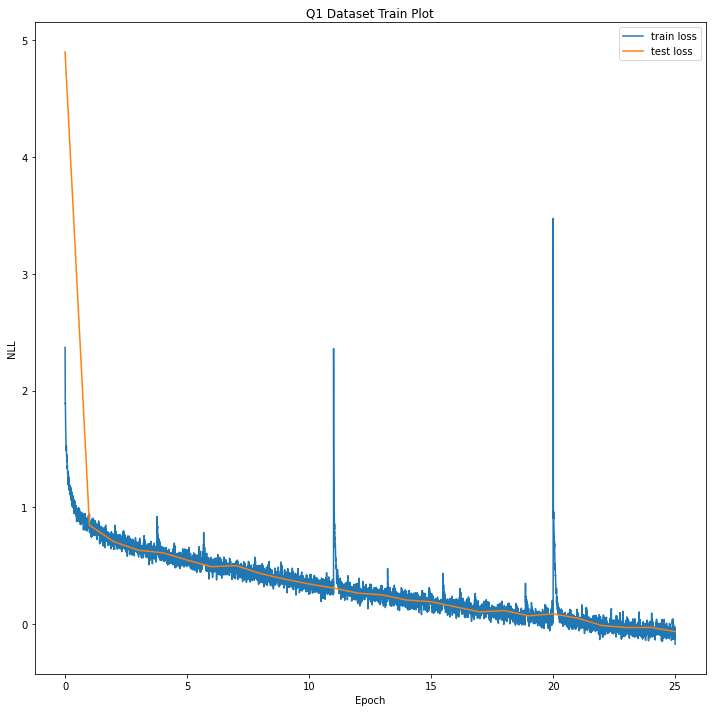

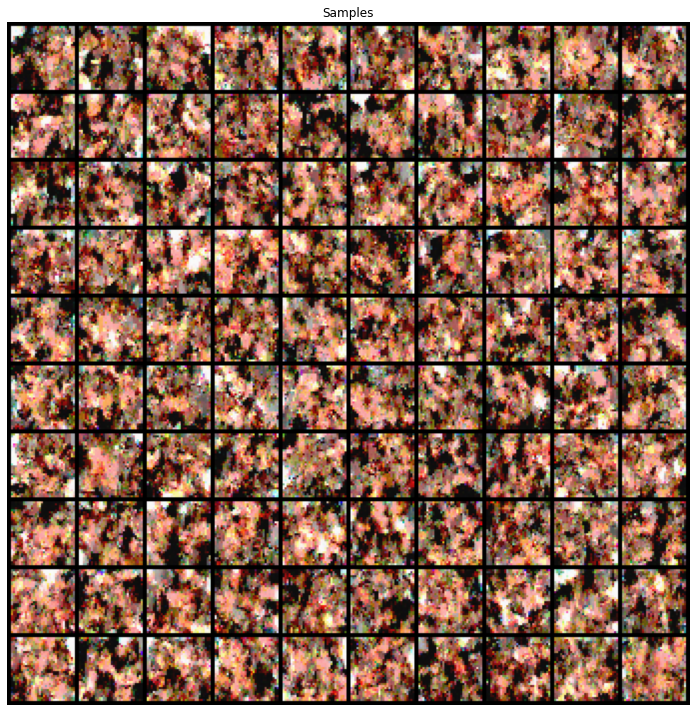

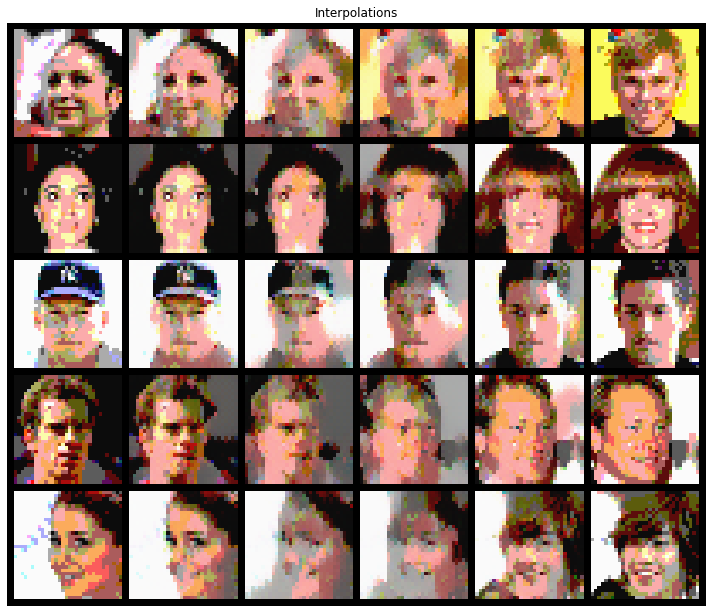

In [ ]:
q1_save_results(q1_a, 'a')

## Part (b): Exploring bad masking schemes

The choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

### Bad masks

In [ ]:
sample_size = (32, 32)
h, w = sample_size

# Triangular pattern
triangular_mask = torch.zeros((3, h, w))
for i in range(h):
  for j in range(w):
    triangular_mask[:, i, j] = (i <= j)

# Half-channel mask
half_mask = torch.zeros((3 * 4, h // 2, w // 2))
half_mask[:, :h // 4] = 1.

### Model, optimizer, hyperparameters

In [ ]:
from torch.optim import Adam

model = RealNVP(triangular_mask, half_mask)
opt = Adam(model.parameters(), 1e-4)

In [ ]:
from copy import deepcopy
saved_epoch = 6

if saved_epoch < 0:
  train_loss_record = []
  test_loss_record = []
else:
  load_dir = '/content/drive/MyDrive/RealNVP'
  
  train_loss_record = np.load(f'{load_dir}/bad_train_loss_{saved_epoch}.npy', allow_pickle=True).tolist()
  test_loss_record = np.load(f'{load_dir}/bad_test_loss_{saved_epoch}.npy', allow_pickle=True).tolist()
  
  saved_parameters = deepcopy(torch.load(f'{load_dir}/bad_real_nvp_{saved_epoch}.pt'))
  model.load_state_dict(saved_parameters)

model = model.to(device)

In [ ]:
!nvidia-smi

Tue Mar 15 20:54:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    59W / 149W |   1147MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train loop

In [ ]:
num_of_pixels = h * w * 3
torch.backends.cudnn.benchmark = True # one epoch runs in 16 min 30 sec on K80, 10 min on T4

for epoch in range(saved_epoch + 1, 10):
  first_epoch = (epoch == 0)
  
  # Run model on train dataset on initialization
  if first_epoch:
    total_loss = compute_test_loss(model, test_data)
    total_loss /= num_of_pixels
    total_loss /= len(test_dataset)
    test_loss_record.append(total_loss + 0.5 * np.log(math.tau))

  # Train dataset
  for i, x in enumerate(train_data, start=1):
    x = preprocess(x)

    # Actnorm on first batch 
    if first_epoch and i == 1:
      with torch.no_grad():
        model.init_actnorm(x)

    # Forward pass
    z, log_d = model(x)
    log_pz = - z ** 2

    loss = - (log_pz.sum(dim=(1, 2, 3)) * 0.5 + log_d).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    train_loss = loss.item() / num_of_pixels
    train_loss_record.append(train_loss + 0.5 * np.log(math.tau))

  # Test dataset
  total_loss = compute_test_loss(model, test_data)
  total_loss /= num_of_pixels
  total_loss /= len(test_dataset)
  test_loss_record.append(total_loss + 0.5 * np.log(math.tau))
  
  print(f"EPOCH : {epoch + 1}")
  print(f"\t loss : {sum(train_loss_record[-50:])}")

  save_dir = '/content/drive/MyDrive/RealNVP'
  torch.save(model.state_dict(), f'{save_dir}/bad_real_nvp_{epoch}.pt')
  np.save(f'{save_dir}/bad_test_loss_{epoch}.npy', np.array(test_loss_record))
  np.save(f'{save_dir}/bad_train_loss_{epoch}.npy', np.array(train_loss_record))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


EPOCH : 8
	 loss : 51.04063149978109
EPOCH : 9
	 loss : 48.53556781450299
EPOCH : 10
	 loss : 47.236805040408065


### Solution

In [ ]:
def q1_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  samples = sample(model)
  interpolations = interpolate(model, test_dataset)
  
  return train_loss_record, test_loss_record, samples, interpolations

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.figsize"] = [10., 10.]

Final Test Loss: 0.9537


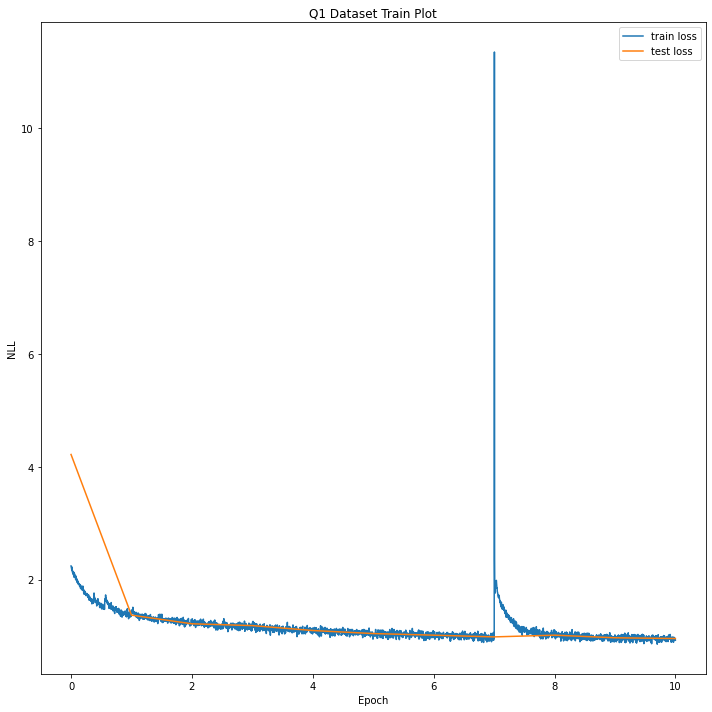

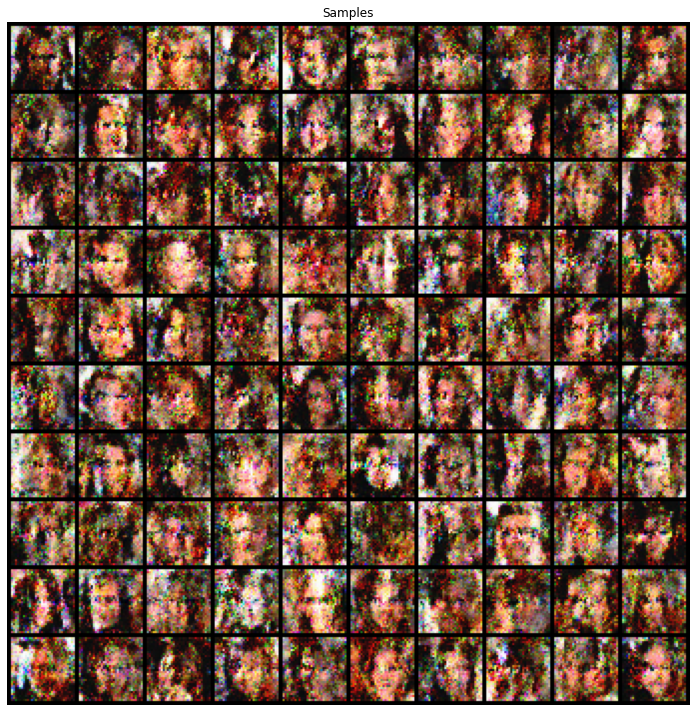

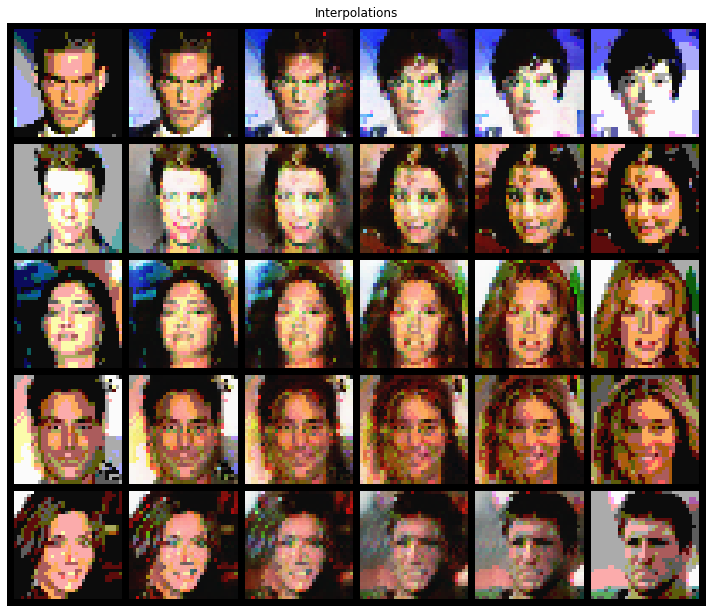

In [ ]:
q1_save_results(q1_b, 'b')

## Bonus 1: Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b1, 'bonus1')

## Bonus 2: Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b2, 'bonus2')